# Construct Knowledge Graphs from the outage rreports

1. Summarize the symptoms, root causes and remediations from the outage report for each outage using BART
2. Create sentence embeddings for each symptom, root cause and remediations by averaging contextualized BERT embeddings for each word
3. Hierarchicaly cluster the outages such that either symptom, root cause or remediation are in the same cluster as per silhouette score
4. Now, create the knowledge graph such that a symptom, root causes and remediation of the same outage is connected, and establish a cluster id for each outage. This will help us traverse across outages based on their clusters

Note: Glove based sentence embedding and LDA Topic Modelling sections are not in use in the current implementation

In [1]:
# pip install transformers

# Entity Extraction

## Entities to extract from the JSON files
Unstructured entities: permanent_solution, root_cause_description, problem_summary, short_term_fix, customer_impacts 

Structutred entities: childIncidents(related CSOs), worstImpacts

I don't see any better way than finding in the json the corresponding key manually

In [1]:
import os
import json
import pandas as pd

In [2]:
json_file = './CSO_data/CSO_all_scraped_Sign.json'
with open(json_file, 'r') as f:
    data = json.load(f)

In [3]:
data.keys()

dict_keys(['17536', '17522', '17510', '17401', '17368', '17088', '16755', '16742', '16649', '16644', '16624', '16589', '16571', '16536', '16532', '16516', '16480', '16425', '16280', '16263', '15934', '15873', '15869', '15849', '15839', '15763', '15739', '15704', '15572', '15560', '15558', '15539', '15493', '15484', '15463', '15461', '15334', '15221', '15215', '15126', '15019', '15005', '14965', '14961', '14947', '14932', '14902', '14886', '14865', '14804', '14797', '14767', '14757', '14722', '14710', '14573', '14452', '14449', '14385', '14379', '14377', '14224', '14073', '14055', '13850', '13840', '13808', '13738', '13678', '13662', '13660', '13630', '13558', '12826', '12686', '12626', '12615', '12606', '12187', '12088', '12078', '12070', '12052', '12041', '11993', '11952', '11892', '11379', '10999', '10991', '10961', '10850', '10835', '10769', '10658', '10625', '10601', '10597', '10459', '10395', '10384', '10336', '10320', '10302', '10286', '10190', '10182', '9828', '9670', '9632', '9

In [108]:
data['10302']

{'isValidCsoId': True,
 'hasAssociatedProblem': True,
 'worstImpacts': {'318654': {'u_affected_service.u_service_id': '318654',
   'u_impact_start': '02-07-2020 06:46:53',
   'u_regions': '',
   'u_customer_impact': 'Between 07:00 AM PT and 08:40 AM PT 02/07/2020, two APIs used by the Dropbox Adobe Sign microservice were issuing 5xx errors. Customers might have encountered errors when trying to update the Dropbox path of a document signed with Adobe Sign. \n\nThere was no data loss, the signed documents could be found at any point at the original path. \n\nThere were no customer complaints received for this issue.',
   'u_impact_type': 'Partially Unavailable',
   'u_jira_id': 'CSOPM-12046',
   'u_impact_id': '26740',
   'u_confirmed_by': 'Mohit Bansal',
   'u_affected_service.name': 'Dropbox Integration Provider',
   'u_impact_percent': '45.75',
   'u_assigned_to.name': 'Mohit Bansal',
   'u_impact_status': 'CONFIRMED',
   'u_impact_duration': '',
   'u_assigned_to.email': 'mbansal@ado

In [4]:
## for parsing HTML in unstructured data
from io import StringIO
import html
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html_data):
    html_data = html.unescape(html_data)
    s = MLStripper()
    s.feed(html_data)
    return s.get_data()

In [5]:
from transformers import pipeline

summarizer1 = pipeline("summarization", model="facebook/bart-large-cnn", tokenizer = "facebook/bart-large-cnn", truncation=True, max_length=1024)   #facebook/bart
summarizer2  = pipeline("summarization", model="t5-large", tokenizer = "t5-large", truncation = True, max_length = 1024)    #tf
summarizer3  = pipeline("summarization", model="philschmid/bart-large-cnn-samsum", tokenizer = "philschmid/bart-large-cnn-samsum", truncation = True, max_length = 1024)


/opt/conda/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [6]:
ensemble_data = {'cso_number':[],'symptom':[], 'root_cause':[], 'remediations':[], 'description':[], 'short_description':[], 'affected_services':[], 'child_cso':[], 'short_term_fix':[], 'customer_impacts':[]}

for cso in data:
    print(cso)
    ensemble_data['cso_number'].append(cso)
    affected_services = ''
    for a_s in data[cso]['worstImpacts']:
        affected_services = affected_services + a_s + ', '
    ensemble_data['affected_services'].append(affected_services[:-2])
    child_cso = ''
    for c_c in data[cso]['primaryIncident']['childIncidents']:
        child_cso = child_cso + c_c  +', '
    ensemble_data['child_cso'].append(child_cso[:-2])
    
    s_text = strip_tags('None' if data[cso]['problems'][0]['u_problem_summary']is None else data[cso]['problems'][0]['u_problem_summary'])
    ensemble_data['symptom'].append(summarizer1(s_text, max_length=120, min_length=0, do_sample=False)[0]['summary_text'])
    
    r_c_text = strip_tags('None' if data[cso]['problems'][0]['u_root_cause_description']is None else data[cso]['problems'][0]['u_root_cause_description'])
    ensemble_data['root_cause'].append(summarizer1(r_c_text, max_length=120, min_length=0, do_sample=False)[0]['summary_text'])
    
    r_text = strip_tags('None' if data[cso]['problems'][0]['u_permanent_solution']is None else data[cso]['problems'][0]['u_permanent_solution'])  
    ensemble_data['remediations'].append(summarizer1(r_text, max_length=120, min_length=0, do_sample=False)[0]['summary_text'])
    
    ensemble_data['description'].append(data[cso]['primaryIncident']['description'])
    ensemble_data['short_description'].append(data[cso]['primaryIncident']['short_description'])
    
    c_i_text = strip_tags('None' if data[cso]['primaryIncident']['u_customer_impacts']is None else data[cso]['primaryIncident']['u_customer_impacts'])
    ensemble_data['customer_impacts'].append(summarizer1(c_i_text, max_length=120, min_length=0, do_sample=False)[0]['summary_text'])
    
    s_t_f_text = strip_tags('None' if data[cso]['problems'][0]['u_short_term_fix']is None else data[cso]['problems'][0]['u_short_term_fix'])
    ensemble_data['short_term_fix'].append(summarizer1(s_t_f_text, max_length=120, min_length=0, do_sample=False)[0]['summary_text'])
    

17536


Your max_length is set to 120, but you input_length is only 55. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)
Your max_length is set to 120, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)
Your max_length is set to 120, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


17522


Your max_length is set to 120, but you input_length is only 12. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=6)
Your max_length is set to 120, but you input_length is only 3. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=1)
Your max_length is set to 120, but you input_length is only 31. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 120, but you input_length is only 4. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=2)


17510


Your max_length is set to 120, but you input_length is only 72. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=36)
Your max_length is set to 120, but you input_length is only 77. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)
Your max_length is set to 120, but you input_length is only 17. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


17401


Your max_length is set to 120, but you input_length is only 26. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)
Your max_length is set to 120, but you input_length is only 45. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)
Your max_length is set to 120, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


17368


Your max_length is set to 120, but you input_length is only 11. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=5)

KeyboardInterrupt



In [7]:
ensemble_df3 = pd.DataFrame(ensemble_data)

In [11]:
ensemble_df3

,cso_number,symptom,root_cause,remediations,description,short_description,affected_services,child_cso,short_term_fix,customer_impacts
0,17536,Adobe sign customized email template (ceMT) mi...,this inadvertently tripped this protection fea...,none,Adobe Sign Customized Email Template users are...,Adobe Sign - Customized Email Template microse...,"316391, 320691",NaN,the BI change was rolled back and the aPO team...,between 2022-05-25 at 22:55 UTC and 2022-05-26...
1,17522,Adobe applications / services use IMS to enabl...,root cause points to canary deployment .,none,Incident description: Cloudwatch check for 5xx...,Identity Management Services,"318561, 318560, 318205, 321727, 320998, 321962...",NaN,rollbacks have been common in the u.s. in the ...,starting on 2022-05-24 between 11:29 UTC to 11...
2,17510,a small subset of users attempting to use the ...,the problem was caused by a misstep in convert...,review manual testing procedure with team memb...,Microsoft Office365 Provider unable to run com...,Microsoft Office365 Provider,317501,NaN,a fix was pushed to production that corrected ...,a small subset of users attempting to use the ...
3,17401,some North America Adobe Sign users might have...,some North America Adobe Sign users might have...,review the sOP for DB nodes upgrades to improv...,Incident description: Adobe Sign NA2 Compose P...,Adobe Sign North America 2,"321671, 323232, 321670, 323231, 323230, 317791...",17402,"DB3 node was set as primary, ending any potent...",some north america Adobe sign users might have...
4,17368,Adobe sign users attempting to combine PDFs us...,sign operates as a distributed system connecte...,bug in jms message handling .,Agreements are getting stuck,Adobe Sign - Adobe Sign North America 3,"322299, 318358",NaN,the PDFcombiner instances were restarted .,users attempting to combine PDFs using the PDF...
...,...,...,...,...,...,...,...,...,...,...
177,6119,one of our NA1 instances was stuck with unknow...,one of our NA1 instances was stuck with Unknow...,the implementation of the auto heal after DNS ...,One instance is unhealthy in the NA1 Region,Sign Microservice - Background Removal,"316383, 316384, 316381, 316382, 316385",NaN,the bad instance was terminated . the good ins...,"between 13:37 PT and 22:15 PT, 214 requests ou..."
178,6065,service encountered two 1 minute intervals of ...,"outage on 3rd party provider, BOX . further de...",no permanent solution being implemented becaus...,AdobeSign integration impacted by an outage on...,Document Cloud - Adobe Sign,315824,NaN,box restored the service .,the issue causing impact has been resolved and...
179,6025,a portion of customers would receive an error ...,issues on provider side caused error responses...,"to minimize risk of, and/or prevent this issue...",Incident description: New Relic check of Mobil...,Adobe Sign NA1 / Mobile Signature Captur,"315824, 317380, 317378, 317377, 317376, 317379",NaN,the vendor resolved their issue and the errors...,"between at 7:57 AM and 9:04 AM PT, some Adobe ..."
180,5990,users in NA1 and NA2 were receiving an error m...,"on january 25, 2018, Adobe sign experienced a ...",the serenity team (Doc cloud SCRUM Team) is go...,Error message on uploaded customer documents.,Document Cloud - AdobeSign,"315824, 317791, 315825, 171, 316248, 316249, 3...",NaN,techops disabled AV scanning during troublesho...,users in NA1 and NA2 were receiving an error m...


In [9]:
ensemble_df3.to_csv('./CSO_data/'+ 'CSO_entities_ensembled_Sign_t5.csv')

In [53]:
ensemble_df3 = pd.read_csv('./CSO_data/'+ 'CSO_entities_ensembled_Sign_bart-large-cnn-samsum.csv', index_col=0)

# BERT-based Sentence Embeddings 

In [54]:
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np
import torch

In [55]:
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True,)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
def bert_text_preparation(text, tokenizer):
    """Preparing the input for BERT
    
    Takes a string argument and performs
    pre-processing like adding special tokens,
    tokenization, tokens to ids, and tokens to
    segment ids. All tokens are mapped to seg-
    ment id = 1.
    
    Args:
        text (str): Text to be converted
        tokenizer (obj): Tokenizer object
            to convert text into BERT-re-
            adable tokens and ids
        
    Returns:
        list: List of BERT-readable tokens
        obj: Torch tensor with token ids
        obj: Torch tensor segment ids
    
    
    """
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)

    # Convert inputs to PyTorch tensors
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors

In [57]:
def get_bert_embeddings(tokens_tensor, segments_tensors, model):
    """Get embeddings from an embedding model
    
    Args:
        tokens_tensor (obj): Torch tensor size [n_tokens]
            with token ids for each token in text
        segments_tensors (obj): Torch tensor size [n_tokens]
            with segment ids for each token in text
        model (obj): Embedding model to generate embeddings
            from token and segment ids
    
    Returns:
        list: List of list of floats of size
            [n_tokens, n_embedding_dimensions]
            containing embeddings for each token
    
    """
    
    # Gradient calculation id disabled
    # Model is in inference mode
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        # Removing the first hidden state
        # The first state is the input state
        hidden_states = outputs[2][1:]

    # Getting embeddings from the final BERT layer
    token_embeddings = hidden_states[-1]
    # Collapsing the tensor into 1-dimension
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    # Converting torchtensors to lists
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings

In [58]:
entities = ['symptom', 'root_cause', 'remediations']

for entity in entities:
    sentence_embeddings = []
    for sentence in ensemble_df3[entity]:
        if type(sentence) != str:
            sentence = "Nothing defined"
        tokenized_text, tokens_tensor, segments_tensors = bert_text_preparation(sentence, tokenizer)
        list_token_embeddings = np.array(get_bert_embeddings(tokens_tensor, segments_tensors, model))
        sentence_embed = np.sum(list_token_embeddings, axis=0)
        sentence_embeddings.append(sentence_embed)
        
    ensemble_df3[f'{entity}_embeddings'] = sentence_embeddings

# Glove based Sentence Embeddings

In [12]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer

In [13]:
# returns a 2d numpy array containing embeddings of words in word_index
def embedding_for_vocab(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1

    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix_vocab

In [14]:
#takes as input a single column dataframe and tokenizes the words 
def tokenize(df,vocab_size, oov_token = "<OOV>"):
    tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
    tokenizer.fit_on_texts(df)
    return tokenizer.word_index

In [15]:
data_path = './CSO_data/CSO_entities_ensembled_Sign.csv'
dataframe = pd.read_csv(data_path, index_col=0)
entities = ['symptom', 'root_cause', 'remediations']

In [16]:
cso_index = {}
for i,cso in enumerate(dataframe['cso_number'].values):
    cso_index[str(cso)] = i

In [10]:
dataframe.head()

NameError: name 'dataframe' is not defined

In [27]:
df = {}
word_index = {}
word_embeddings = {}

embedding_dim = 50
filepath = './glove/glove.6B.' + str(embedding_dim) + 'd.txt'

for entity in entities:
    print(entity)
    sentence_embeddings_entity = []
    missed = []
    df[entity] = ensemble_df3[entity].astype("str")
    word_index[entity] = tokenize(df[entity], 100000)
    word_embeddings[entity] = embedding_for_vocab(filepath, word_index[entity], embedding_dim)
    
    for sentence in df[entity]:
        if type(sentence) != str:
            sentence = "Nothing defined"
        emb = np.zeros((50,))
        n_of_words = 0
        words = sentence.split()
        for word in words:
            if word in word_index[entity]:
                emb += word_embeddings[entity][word_index[entity][word]] 
                n_of_words += 1
            else:
                missed.append(word)
        if (n_of_words > 0):
            emb = emb/n_of_words
        sentence_embeddings_entity.append(emb)
        
    ensemble_df3[f'{entity}_embeddings'] = sentence_embeddings_entity
    


symptom
root_cause
remediations


# Clustering

In [59]:
cso_index = {}
for i,cso in enumerate(ensemble_df3['cso_number'].values):
    cso_index[str(cso)] = i

In [60]:
## clustering the sentence embeddings

def agglo_score(blobs, min_clusters, max_clusters, elbow = False, sil_score = True):
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.metrics import silhouette_score
    params = {'n_clusters':2}
    score =[]
    for i in range(min_clusters, max_clusters+1):
        params['n_clusters'] = i
        model = AgglomerativeClustering().set_params(**params)
        score.append(silhouette_score(blobs, model.fit_predict(blobs)))
    
    return score


def agglo(blobs, n_clusters):
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.metrics import silhouette_score
    
    clustering = AgglomerativeClustering(n_clusters=n_clusters).fit(blobs)
    return clustering


def affinity_prp(blobs, damping = 0.5, random_state = 5, max_iter = 200):
    from sklearn.cluster import AffinityPropagation
    params = {'damping': 0.5, 'random_state':5, 'max_iter':200}
    params['damping'] = damping
    params['random_state'] = random_state
    params['max_iter'] = max_iter
    model = AffinityPropagation().set_params(**params)
    return model.fit(blobs)

In [61]:
opt_score = {}
clustering = {} 

# for symptom, root cause and remediations each, create an agglomeratice clustering. Best clustering for individual entities are chosen based on silhouette score
for entity in entities:
    opt_score[entity] = agglo_score(ensemble_df3[f'{entity}_embeddings'].tolist(), 3, 180)

# clustering['root_cause'] = affinity_prp(sentence_embeddings['root_cause'], 0.5,5,1000)
# clustering['remediations'] = affinity_prp(sentence_embeddings['remediations'])

# opt_clusters['root_cause'] = max(clustering['root_cause'].labels_)
# opt_clusters['remediations'] = max(clustering['remediations'].labels_)


In [62]:
print(f"Symptom nclusters : {np.argmax(opt_score['symptom'])}")
print(f"Root Cause nclusters : {np.argmax(opt_score['root_cause'])}")
print(f"Remediation nclusters : {np.argmax(opt_score['remediations'])}")

Symptom nclusters : 106
Root Cause nclusters : 115
Remediation nclusters : 121


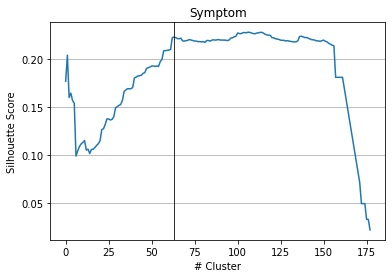

In [140]:
### import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(len(opt_score['symptom'])), opt_score['symptom'])
plt.title("Symptom")
plt.xlabel('# Cluster')
plt.ylabel('Silhouette Score')
plt.grid(axis='y')
plt.axvline(x=63, color='k', linewidth=0.8)
# plt.show()
plt.savefig('Silhouette_Symptom.jpg', dpi=400)

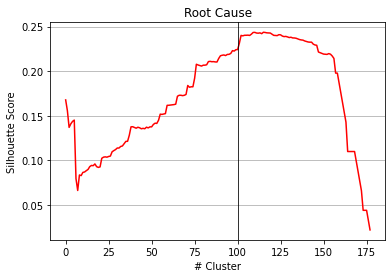

In [139]:
plt.figure()
plt.plot(range(len(opt_score['root_cause'])), opt_score['root_cause'], color='r')
plt.title("Root Cause")
plt.xlabel('# Cluster')
plt.ylabel('Silhouette Score')
plt.grid(axis='y')
plt.axvline(x=100, color='k', linewidth=0.8)
# plt.show()
plt.savefig('Silhouette_RootCause.jpg', dpi=400)

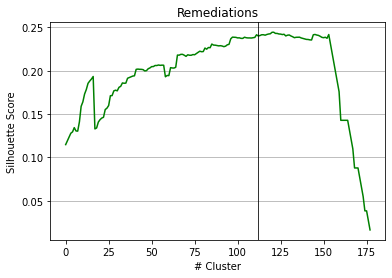

In [138]:
plt.figure()
plt.plot(range(len(opt_score['remediations'])), opt_score['remediations'], color='g')
plt.title("Remediations")
plt.xlabel('# Cluster')
plt.ylabel('Silhouette Score')
plt.grid(axis='y')
plt.axvline(x=112, color='k', linewidth=0.8)
# plt.show()
plt.savefig('Silhouette_Remediation.jpg', dpi=400)

In [66]:
for entity in entities:
    opt_cluster = np.argmax(opt_score[entity])
    if entity == "symptom":
        opt_cluster = 63
    if entity == "root_cause":
        opt_cluster = 100
    if entity == "remediations":
        opt_cluster = 112
    clustering[entity] = agglo(ensemble_df3[f'{entity}_embeddings'].tolist(), opt_cluster)
    

In [67]:
# Combining the clusters, i.e., put all csos in a cluster if symptom or root cause or remediation are in their same individual cluster
combined_cluster_label_dict = {}
c = 0
for i in range(len(ensemble_df3)):
    if i in combined_cluster_label_dict:
        continue
        
    combined_cluster_label_dict[i] = c
    
    symptom_cluster = clustering['symptom'].labels_[i]
    indices = np.where(clustering['symptom'].labels_ == symptom_cluster)[0]
    for j in indices:
        if j not in combined_cluster_label_dict:
            combined_cluster_label_dict[j] = c
    
    print(combined_cluster_label_dict)
    
    rc_cluster = clustering['root_cause'].labels_[i]
    indices = np.where(clustering['root_cause'].labels_ == rc_cluster)[0]
    for j in indices:
        if j not in combined_cluster_label_dict:
            combined_cluster_label_dict[j] = c
        
    print(combined_cluster_label_dict)
        
    rem_cluster = clustering['remediations'].labels_[i]
    indices = np.where(clustering['remediations'].labels_ == rem_cluster)[0]
    for j in indices:
        if j not in combined_cluster_label_dict:
            combined_cluster_label_dict[j] = c
        
    print(combined_cluster_label_dict)
    print('')
    
    c += 1

{0: 0}
{0: 0, 55: 0, 137: 0, 140: 0, 147: 0, 152: 0}
{0: 0, 55: 0, 137: 0, 140: 0, 147: 0, 152: 0, 1: 0, 6: 0, 61: 0, 69: 0, 139: 0}

{0: 0, 55: 0, 137: 0, 140: 0, 147: 0, 152: 0, 1: 0, 6: 0, 61: 0, 69: 0, 139: 0, 2: 1, 26: 1, 62: 1, 134: 1}
{0: 0, 55: 0, 137: 0, 140: 0, 147: 0, 152: 0, 1: 0, 6: 0, 61: 0, 69: 0, 139: 0, 2: 1, 26: 1, 62: 1, 134: 1, 80: 1, 88: 1}
{0: 0, 55: 0, 137: 0, 140: 0, 147: 0, 152: 0, 1: 0, 6: 0, 61: 0, 69: 0, 139: 0, 2: 1, 26: 1, 62: 1, 134: 1, 80: 1, 88: 1, 31: 1}

{0: 0, 55: 0, 137: 0, 140: 0, 147: 0, 152: 0, 1: 0, 6: 0, 61: 0, 69: 0, 139: 0, 2: 1, 26: 1, 62: 1, 134: 1, 80: 1, 88: 1, 31: 1, 3: 2, 25: 2, 99: 2}
{0: 0, 55: 0, 137: 0, 140: 0, 147: 0, 152: 0, 1: 0, 6: 0, 61: 0, 69: 0, 139: 0, 2: 1, 26: 1, 62: 1, 134: 1, 80: 1, 88: 1, 31: 1, 3: 2, 25: 2, 99: 2}
{0: 0, 55: 0, 137: 0, 140: 0, 147: 0, 152: 0, 1: 0, 6: 0, 61: 0, 69: 0, 139: 0, 2: 1, 26: 1, 62: 1, 134: 1, 80: 1, 88: 1, 31: 1, 3: 2, 25: 2, 99: 2, 13: 2, 74: 2, 79: 2}

{0: 0, 55: 0, 137: 0, 140: 0, 147: 0,

In [68]:
combined_cluster_label = np.zeros(len(ensemble_df3))

for k,v in combined_cluster_label_dict.items():
    combined_cluster_label[k] = v

In [69]:
combined_cluster_label

array([ 0.,  0.,  1.,  2.,  3.,  4.,  0.,  5.,  5.,  6.,  7.,  8.,  9.,
        2., 10.,  5.,  3., 11., 10., 12., 13.,  3., 14.,  6., 15.,  2.,
        1., 16., 17., 11., 14.,  1., 18.,  3., 19., 19.,  4., 10., 20.,
        7., 21., 21.,  6., 14., 20.,  5., 22., 23., 24., 25., 25.,  6.,
       26., 10.,  5.,  0., 26.,  5., 27., 28., 28.,  0.,  1.,  9.,  9.,
        3., 29., 22., 30.,  0., 30.,  9.,  6., 14.,  2., 16., 31., 32.,
        6.,  2.,  1., 10., 32., 10., 10., 20., 33.,  9.,  1., 14., 29.,
       31., 34., 29., 34., 34., 34., 35.,  3.,  2.,  6., 20., 30., 20.,
       36., 14., 36., 10., 37., 37., 38., 14., 39., 40., 31., 41., 33.,
       42., 41., 39., 43., 40., 12., 40., 44., 40., 45., 46., 46., 44.,
       47.,  6., 10., 33.,  1., 48., 49.,  0., 40.,  0.,  0., 49., 50.,
       50., 50.,  6., 50.,  0.,  6.,  6.,  8., 15.,  0., 51., 51., 10.,
       44., 40., 10., 10.,  6., 24., 15., 52., 10., 10., 52., 10., 14.,
       10.,  6.,  6., 10.,  3., 10., 52., 10., 49., 14.,  6.,  6

In [70]:
np.unique(combined_cluster_label, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52.]),
 array([11,  7,  6,  7,  2,  6, 16,  2,  2,  5, 19,  2,  2,  1,  9,  3,  2,
         1,  1,  2,  5,  2,  2,  1,  2,  2,  2,  1,  2,  3,  3,  3,  2,  3,
         4,  1,  2,  2,  1,  2,  6,  2,  1,  1,  4,  1,  2,  1,  1,  3,  4,
         2,  3]))

## Scatterplot
Shows cluster of symptoms in a t-SNE plot for the paper

In [72]:
from sklearn.manifold import TSNE
import seaborn as sns

In [83]:
embed = ensemble_df3['symptom_embeddings'].tolist()

In [85]:
tsne = TSNE(n_components=2, verbose=1, learning_rate='auto', perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(np.array(embed))

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 182 samples in 0.001s...
[t-SNE] Computed neighbors for 182 samples in 0.373s...
[t-SNE] Computed conditional probabilities for sample 182 / 182
[t-SNE] Mean sigma: 72.524829
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.459507
[t-SNE] KL divergence after 300 iterations: 0.685619


In [89]:
df = pd.DataFrame()
df["y"] = combined_cluster_label
df["comp-1"] = tsne_results[:,0]
df["comp-2"] = tsne_results[:,1]

In [92]:
top_cl = [9,
20,
40,
5,
2,
3,
1,
14,
0,
6,
10]

In [109]:
top_5_cl = [3,1, 14,0,6,10]

In [110]:
df1 = df[df["y"].isin(top_5_cl)]

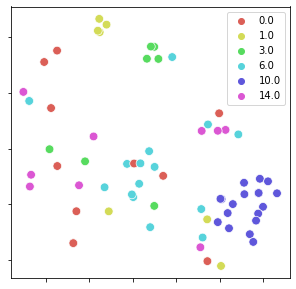

In [122]:
plt.figure(figsize=(5,5))
g1 = sns.scatterplot(x="comp-1", y="comp-2", hue=df1.y.tolist(),
                palette=sns.color_palette("hls", 6),
                data=df1, s=75)
g1.set(xticklabels=[])
g1.set(yticklabels=[])
g1.set(xlabel=None)
g1.set(ylabel=None)
fig = g1.get_figure()
fig.savefig("Scatterplot_Clusters_top6.jpg", dpi=400)

## LDA Topic Modelling

In [92]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['adobe', 'sign', 'customers', 'experience', 'would', 'send', 'pt', 'utc'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarchakr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [93]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = ensemble_df[['description']].values.tolist()
data_words = list(sent_to_words(data))

data_words = remove_stopwords(data_words)

In [94]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
print(data_words[0])
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

['customized', 'email', 'template', 'users', 'experiencing', 'failures']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [95]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.076*"nincident" + 0.063*"check" + 0.060*"time" + 0.051*"description" + '
  '0.051*"incident" + 0.049*"start" + 0.025*"transaction" + 0.024*"pingdom" + '
  '0.023*"dd" + 0.023*"failure"'),
 (1,
  '0.025*"failing" + 0.025*"may" + 0.025*"multiple" + 0.025*"azure" + '
  '0.025*"eu" + 0.017*"high" + 0.017*"google" + 0.017*"load" + 0.017*"active" '
  '+ 0.017*"social"'),
 (2,
  '0.092*"nincident" + 0.085*"time" + 0.053*"description" + 0.053*"start" + '
  '0.053*"incident" + 0.050*"check" + 0.033*"escalation" + 0.032*"auto" + '
  '0.030*"cso" + 0.030*"launched"'),
 (3,
  '0.034*"service" + 0.034*"documents" + 0.034*"eu" + 0.023*"unable" + '
  '0.023*"error" + 0.023*"na" + 0.015*"pingdom" + 0.014*"failing" + '
  '0.012*"preventing" + 0.012*"showing"'),
 (4,
  '0.054*"time" + 0.048*"nincident" + 0.044*"na" + 0.027*"start" + '
  '0.027*"incident" + 0.027*"description" + 0.023*"alert" + 0.022*"escalation" '
  '+ 0.022*"pingdom" + 0.018*"compose"'),
 (5,
  '0.019*"cso" + 0.019*"check" + 

In [64]:
df_symptom.to_frame()['symptom'][0]

'Adobe sign customized email template (ceMT) microservice was not operating as expected . four enterprise users (ncr corporation, humana, HPE, and WarnerMedia) had filed support tickets with Customer Experience . Adobe post office reported an error calling sendMail: "Your credentials have been temporarily disabled"'

# Creating the Graph

In [91]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


In [39]:
import networkx as nx
import matplotlib.pyplot as plt

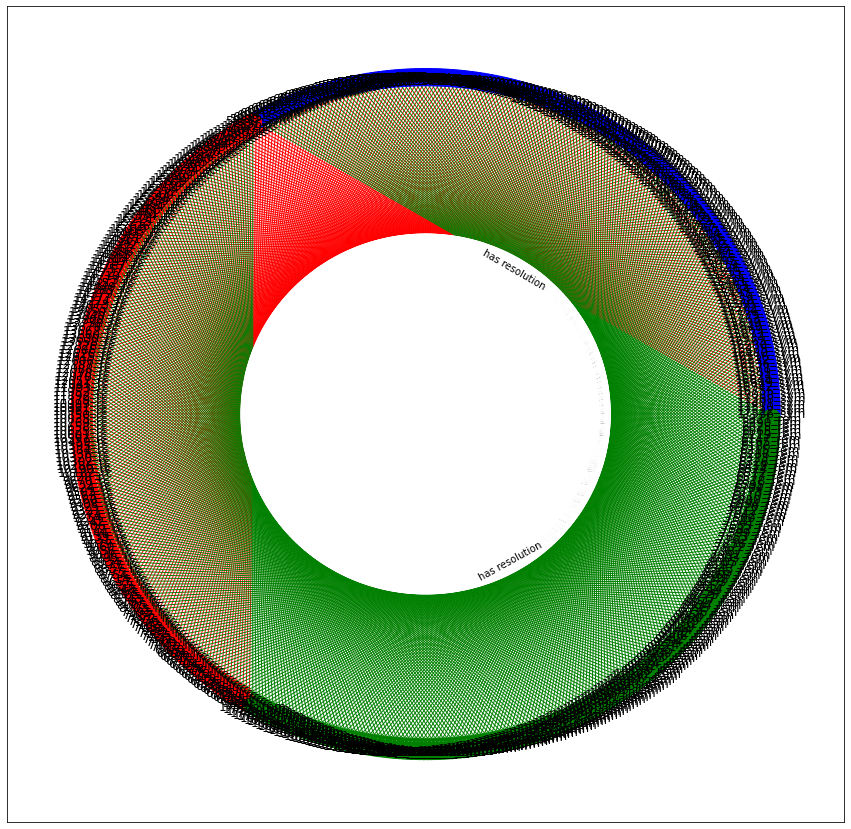

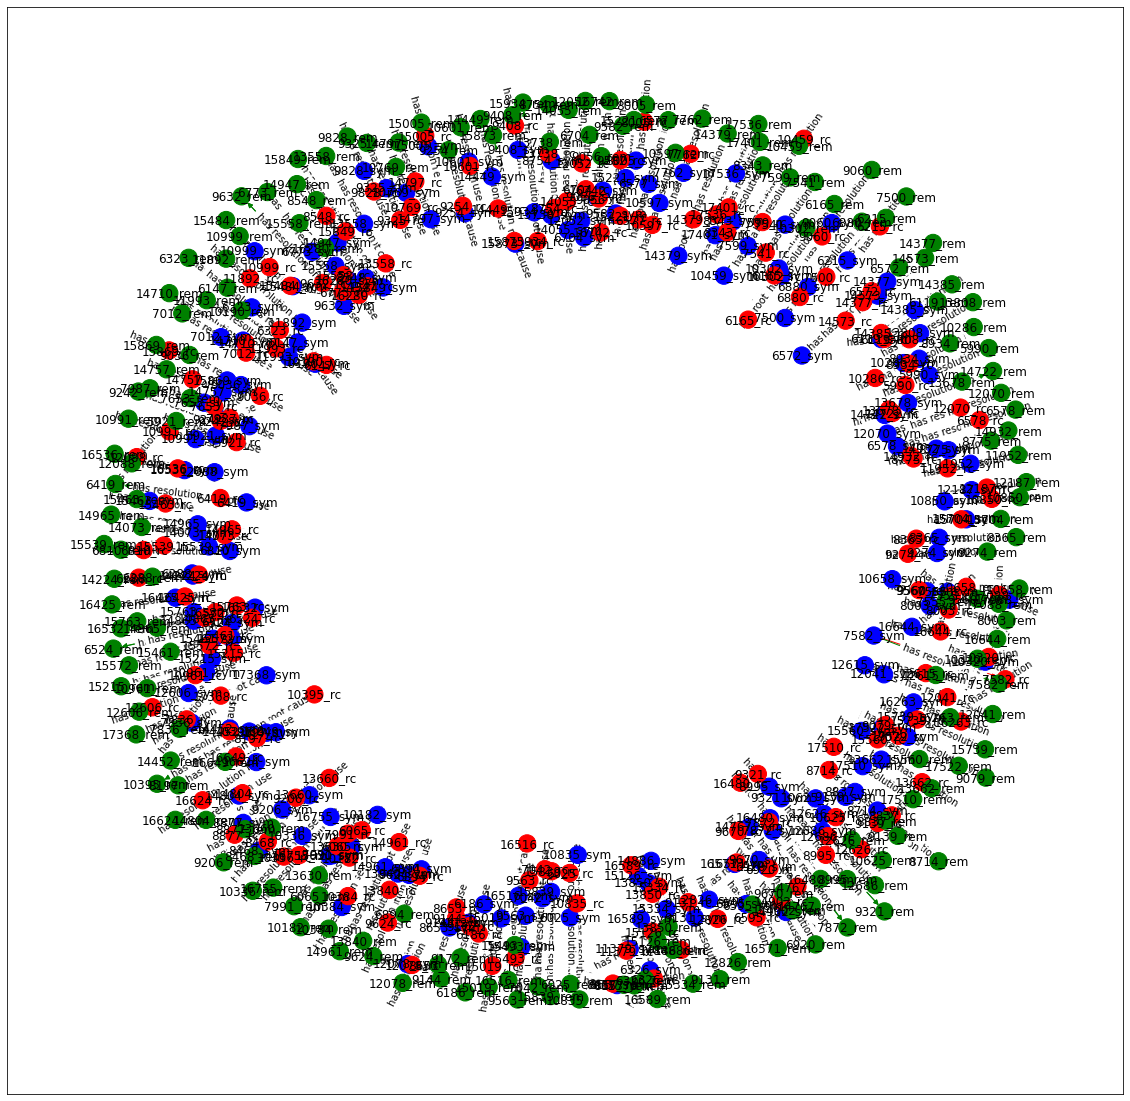

In [40]:
entity_ab = { 'symptom': 'sym', 'root_cause': 'rc', 'remediations': 'rem'}
entity_exp = {'sym' : 'symptom', 'rc' : 'root_cause', 'rem' : 'remediations'}
g = nx.DiGraph()
## nodes have color and labels
## edges have color and laebls too

edge_labels = dict()
color_map = []
edge_color = []

colors = ['blue', 'red', 'green', 'yellow', 'brown', 'purple']
i = 0
for entity in entities:
    ini = len(g.nodes())
    for cso in cso_index:
        kwargs = {}
        kwargs['label'] = ensemble_df3[entity][cso_index[cso]]
        kwargs['color'] = colors[i]
        kwargs['type'] = entity
        kwargs['cluster_id'] = combined_cluster_label[cso_index[cso]]
        g.add_node(cso + '_' + entity_ab[entity], **kwargs)
    # g.add_nodes_from(df[entity])
    # fin = len(g.nodes())
    # for j in range(fin - ini):
    #     color_map.append(colors[i])
    i = i+1

for cso in cso_index:
    kwargs = {}
    kwargs['label'] = 'has root cause'
    kwargs['color'] = 'red'
    g.add_edge(cso + '_sym', cso + '_rc', **kwargs)
    kwargs['label'] = 'has resolution'
    kwargs['color'] = 'green'
    g.add_edge(cso + '_sym', cso + '_rem', **kwargs)
    g.add_edge(cso + '_rc', cso + '_rem', **kwargs )
    # edge_labels[cso + '_sym', cso + '_rc'] = 'has root cause'
    # edge_labels[cso + '_sym', cso + '_rem'] = 'has resolution'
    # edge_labels[cso + '_rc', cso + '_rem'] = 'has resolution'
# no_of_rows_in_entity = len(df['symptom'])
# for i in range(no_of_rows_in_entity):
#     g.add_edge(df['symptom'][i], df['root_cause'][i], label = 'has root cause')
#     g.add_edge(df['symptom'][i], df['remediations'][i], label = 'has resolution')
#     g.add_edge(df['root_cause'][i], df['remediations'][i], label = 'has resolution')
#     edge_labels[df['symptom'][i], df['root_cause'][i]] = 'has root cause'
#     edge_labels[df['symptom'][i], df['remediations'][i]] = 'has resolution'
#     edge_labels[df['root_cause'][i], df['remediations'][i]] = 'has resolution'


#figure = plt.plot()
color_map = [i[1]['color'] for i in list(g.nodes(data = True))]
for i in list(g.edges(data = True)):
    edge_labels[i[0],i[1]] = i[2]['label']
edge_color = [i[2]['color'] for i in list(g.edges(data = True))]

plt.figure(1, figsize = (15,15))
pos = nx.circular_layout(g)
nx.draw_networkx_nodes(g, pos = pos, node_color = color_map)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edges(g, pos, edge_color =  edge_color)
nx.draw_networkx_edge_labels(g, pos, edge_labels = edge_labels)
plt.show()

# k = 3  
# for entity in entities:
#     for label in range(max(clustering[entity].labels_)):
#         cluster_node = entity + str(label)
#         kwargs = {}
#         kwargs['label'] = 'cluster_label_here'
#         kwargs['color'] = colors[k]
#         kwargs['type'] = 'cluster'
#         g.add_node(cluster_node,**kwargs)
#         color_map.append(colors[k])
#         indices, = np.where(clustering[entity].labels_ == label)
#         kwargs = {}
#         for i in indices:
#                 kwargs['label'] = 'has type'
#                 kwargs['color'] = 'orange'
#                 g.add_edge(str(list(dataframe['cso_number'])[i]) + '_'  + entity_ab[entity], cluster_node, **kwargs)
#     k += 1

# color_map = [i[1]['color'] for i in list(g.nodes(data = True))]
# for i in list(g.edges(data = True)):
#     edge_labels[i[0],i[1]] = i[2]['label']
# edge_color = [i[2]['color'] for i in list(g.edges(data = True))]
    
plt.figure(2, figsize = (20,20))
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos = pos, node_color = color_map)
nx.draw_networkx_labels(g, pos)
nx.draw_networkx_edges(g, pos, edge_color =  edge_color)
nx.draw_networkx_edge_labels(g, pos, edge_labels = edge_labels)
plt.show()

In [41]:
import pickle

pickle.dump(g, open('./CSO_data/KG_pickle_clustered_NEW.gpickle', 'wb'))